In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

from emccd_detect import emccd_detect
meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-12-21 14:27:06,477	INFO worker.py:1636 -- Started a local Ray instance.


1.3624486320346218e-17 sr
	Flux for wavelength 8.130e-07 m: 3.998e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 3.840e+08 ph / (s m2)
	Flux for wavelength 8.370e-07 m: 3.691e+08 ph / (s m2)
Total flux: 1.153e+09 ph / (s m2)


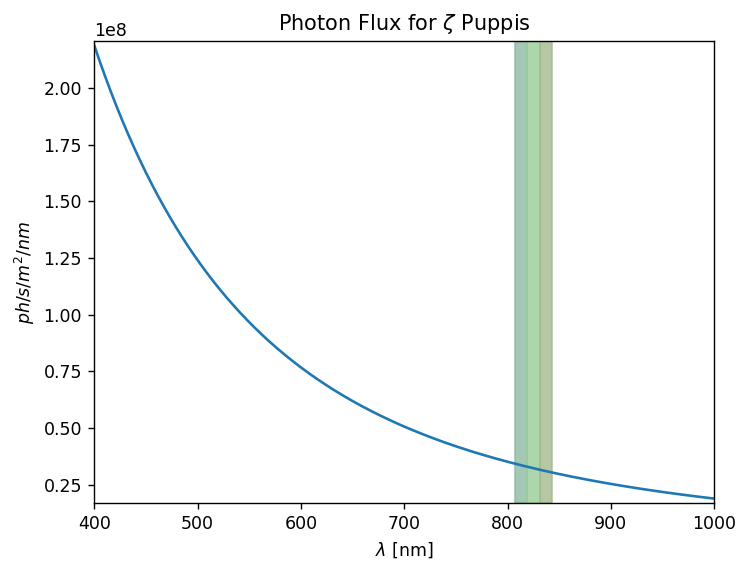

In [2]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 825e-9*u.m

nwaves = 3
bandwidth = 2.9/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
print(f'Total flux: {total_flux:.3e}')

In [3]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

In [4]:
em_gain = 200
full_well_image=60000.  # e-
full_well_serial=100000.  # e-
#status=1,
dark_current=0.0028  # e-/pix/s
dark_current=1.5/3600  # e-/pix/s
cic=0.02  # e-/pix/frame
read_noise=120.  # e-/pix/frame
bias=250.  # e-
qe=0.5
cr_rate=0.  # hits/cm^2/s
pixel_pitch=13e-6  # m
eperdn=1 #7.,
nbits=32
numel_gain_register=604

emccd = emccd_detect.EMCCDDetect(em_gain=em_gain,
                                    full_well_image=full_well_image,  # e-
                                    full_well_serial=full_well_serial,  # e-
                                    #status=status,
                                    dark_current=dark_current,  # e-/pix/s
                                    cic=cic,  # e-/pix/frame
                                    read_noise=read_noise,  # e-/pix/frame
                                    bias=bias,  # e-
                                    qe=qe,
                                    cr_rate=cr_rate,  # hits/cm^2/s
                                    pixel_pitch=pixel_pitch,  # m
                                    eperdn=eperdn,
                                    nbits=nbits,
                                    numel_gain_register=numel_gain_register,
                                    meta_path=meta_path
                                    )

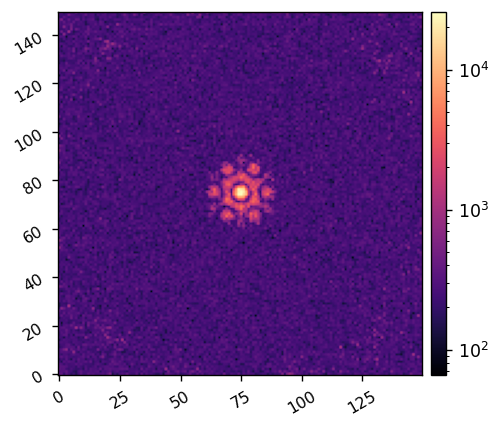

Generating photon noise for frame 1.
Generating photon noise for frame 2.
Generating photon noise for frame 3.
Generating photon noise for frame 4.


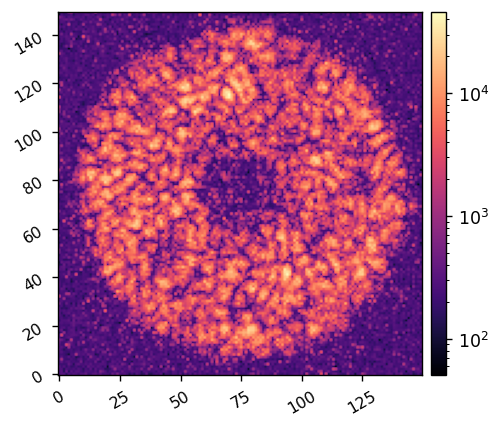

Generating photon noise for frame 1.
Generating photon noise for frame 2.
Generating photon noise for frame 3.
Generating photon noise for frame 4.
Normalizing to max value


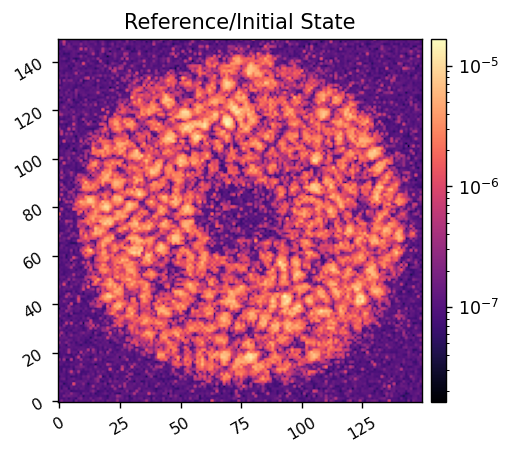

In [5]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, dm1_ref=dm1_flat, dm2_ref=dm2_flat)

mode.use_photon_noise = True
mode.EMCCD = emccd

unocc_exp_time = 0.00001
unocc_em_gain = 200

mode.set_actor_attr('use_fpm',False)
mode.Nframes = 5
mode.exp_time = unocc_exp_time
mode.EMCCD.em_gain = unocc_em_gain

ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, lognorm=True)

mode.set_actor_attr('use_fpm',True)
mode.Nframes = 4
mode.exp_time = 0.25
mode.EMCCD.em_gain = 750

occ_im = mode.snap(quiet=False)
imshow1(occ_im, lognorm=True)

mode.normalize = True
mode.Imax_ref = xp.max(ref_unocc_im)
mode.exp_time_ref = unocc_exp_time
mode.em_gain_ref = unocc_em_gain

ref_im = mode.snap(quiet=False)
imshow1(ref_im, 'Reference/Initial State', lognorm=True)

# Create dark hole ROI to calibrate and control

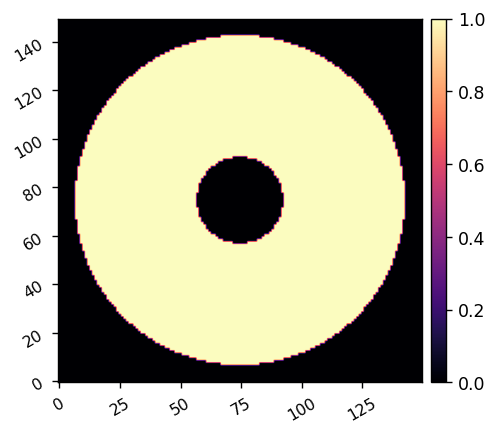

1.526437085044516e-06


In [6]:
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)

mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration and probe modes

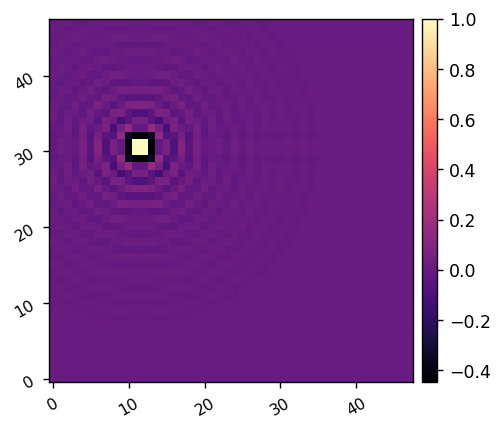

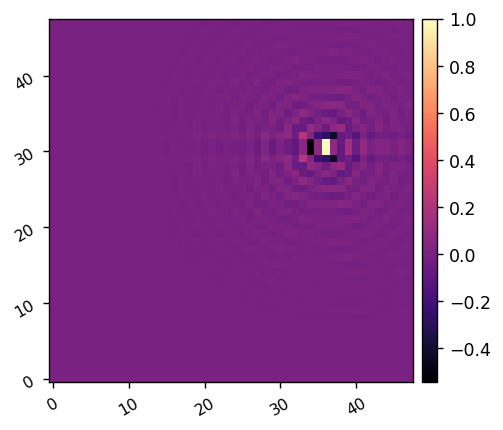

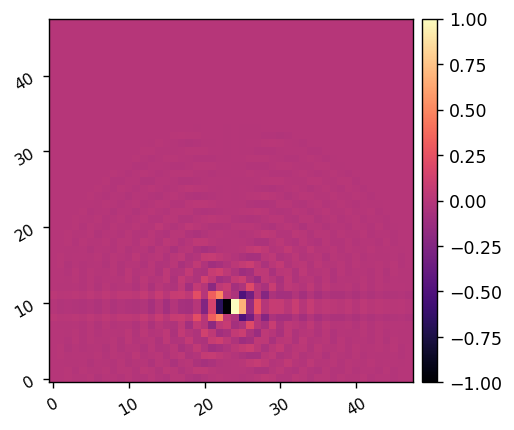

In [7]:
probe_amp = 10e-9
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2,
                                          shift=[(-12,7), (12,7),(0,-14), (0,0)], nprobes=3,
                                           use_weighting=True,
                                             plot=True)

(4096, 4608)


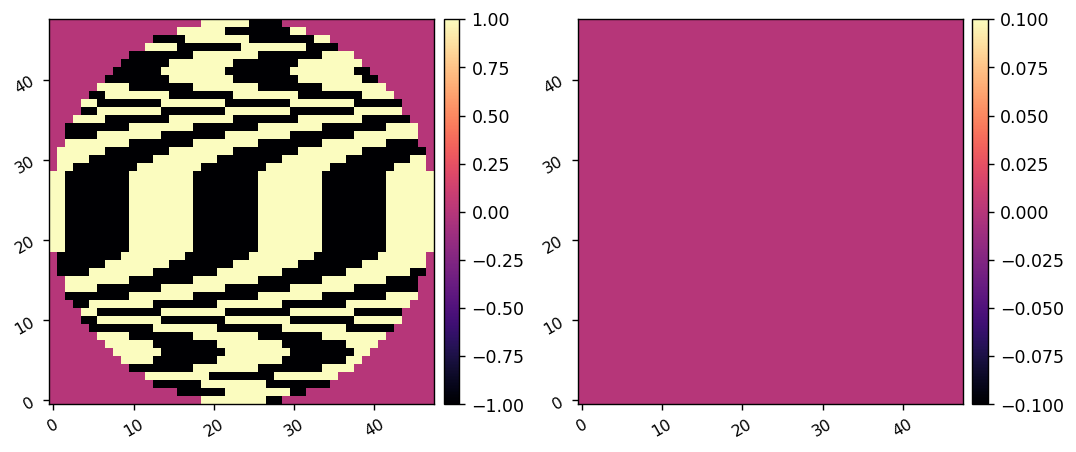

In [8]:
calib_amp = 10e-9
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


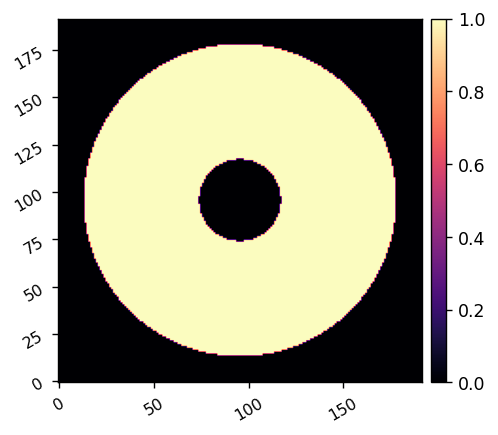

97679.57183173961
(4096,)


In [133]:
reload(utils)
oversamp = 4

had_modes = xp.array(calib_modes)
ft_modes = []
for i in range(calib_modes.shape[0]//2):
    had_mode = had_modes[i,:mode.Nact**2].reshape(mode.Nact, mode.Nact)
    # print(type(had_mode))
    ft_modes.append(xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(utils.pad_or_crop(had_mode, mode.Nact*oversamp)))))
mode_freqs = xp.abs(xp.array(ft_modes))**2

mode_freq_mask_pxscl = 1/oversamp
x = (xp.linspace(-mode.Nact*oversamp//2, mode.Nact*oversamp//2-1, mode.Nact*oversamp) + 1/2)*mode_freq_mask_pxscl
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2+y**2)
mode_freq_mask = (r>5.4)*(r<20.6)
imshow1(mode_freq_mask)

reference_mode = 10
max_freq_response = xp.max(mode_freqs[reference_mode, mode_freq_mask])
print(max_freq_response)

scale_factors = []
for i in range(mode_freqs.shape[0]):
    scale_factors.append(max_freq_response/xp.max(mode_freqs[i,mode_freq_mask]))
scale_factors = ensure_np_array(xp.array(scale_factors))
scale_factors[scale_factors>2] = 2
scale_factors[scale_factors<1/2] = 1/2

scale_factors = np.concatenate([scale_factors,scale_factors])
print(scale_factors.shape)

In [134]:
scale_factors[2]

0.5

0.9402815574694389 4.701407787347194e-09


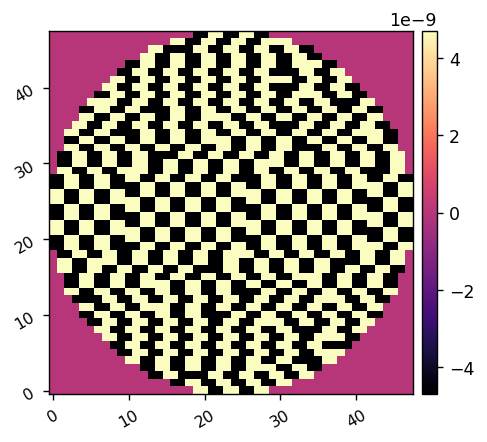

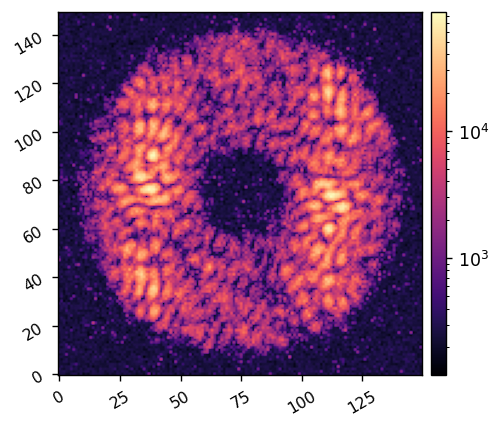

In [140]:
mode.normalize = True
mode.normalize=False
mode.EMCCD.em_gain = 400
mode.exp_time = 0.05
mode.Nframes = 10

calib_amp = 5e-9
probe_amp = 25e-9

i = 34
had_mode = calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact)
scaled_calib_amp = calib_amp * scale_factors[i]
print(scale_factors[i], scaled_calib_amp)
imshow1(scaled_calib_amp*had_mode)

mode.add_dm1(scaled_calib_amp*had_mode)
mode.add_dm1(probe_amp*probe_modes[0])
im = mode.snap()
mode.add_dm1(-probe_amp*probe_modes[0])
mode.add_dm1(-scaled_calib_amp*had_mode)

imshow1(im, lognorm=True,)
# imshow2(im, im-ref_im, lognorm1=True)

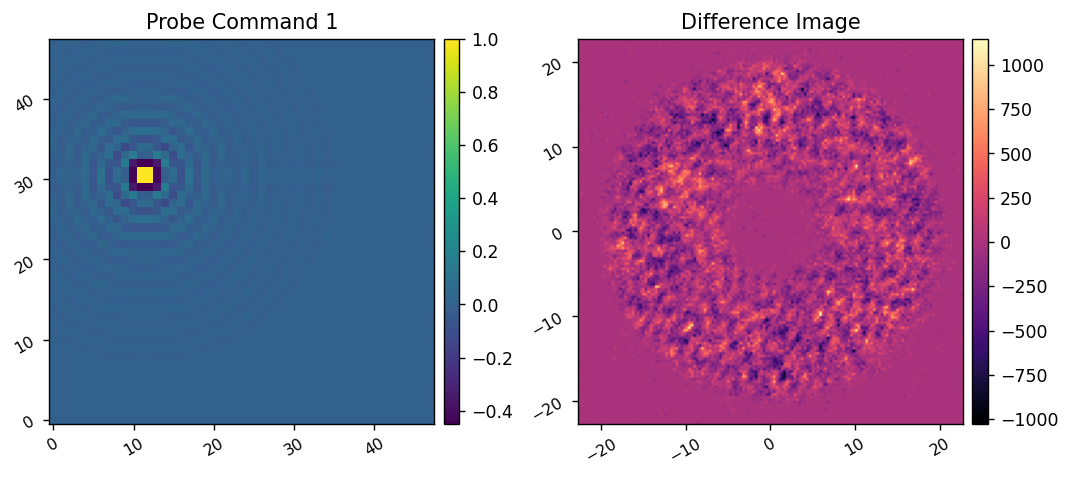

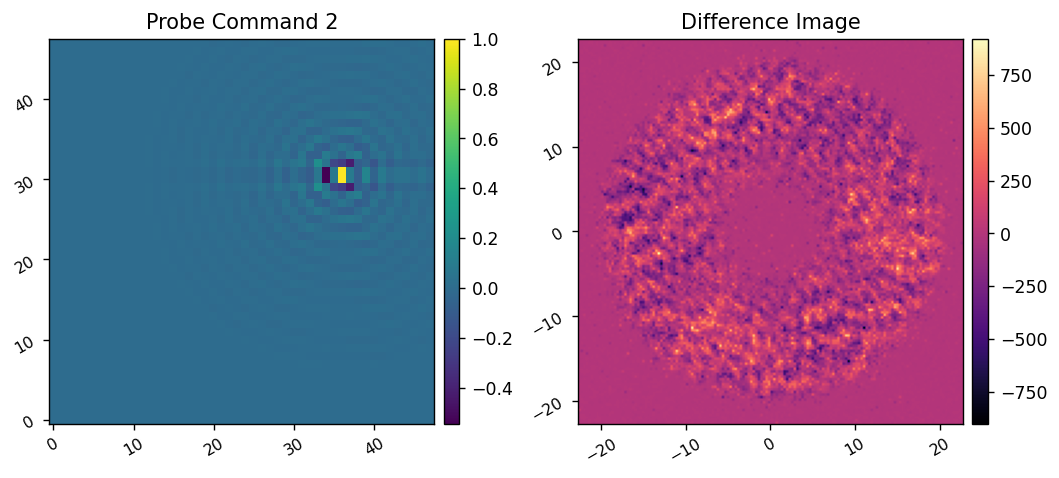

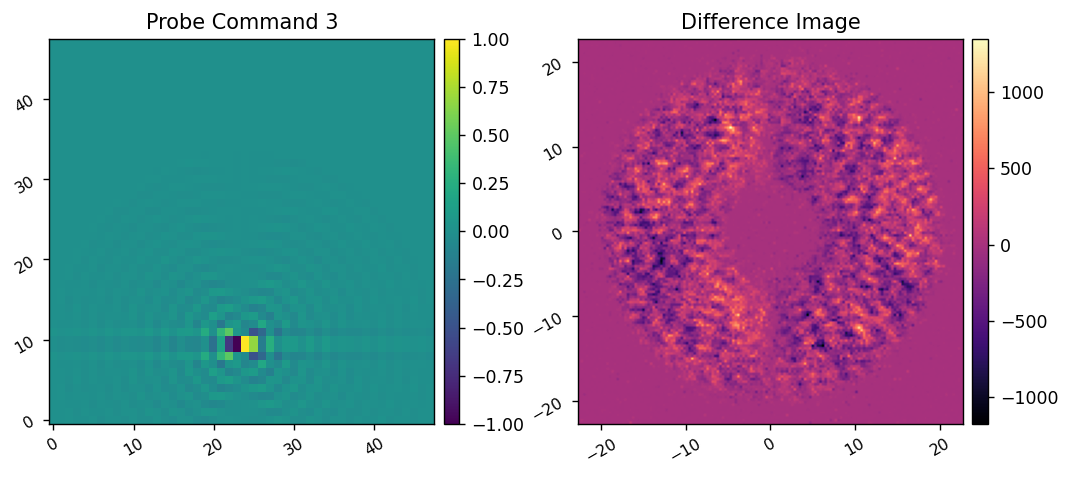

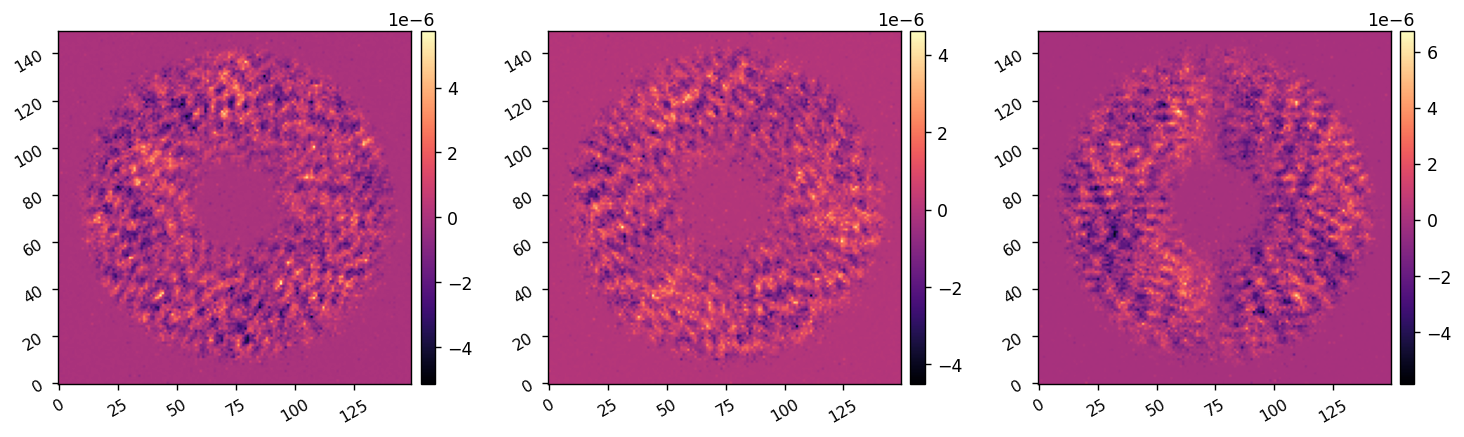

In [120]:
reload(iefc_2dm)
mode.normalize = True

calib_amp = 2.5e-9
probe_amp = 25e-9

mode.add_dm1(calib_amp*calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = 2*calib_amp*differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
mode.add_dm1(-calib_amp*calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))

imshow3(ims[0], ims[1], ims[2])


Calibrating iEFC...
	Calibrated mode 2/2 in 23.897s
Calibration complete.


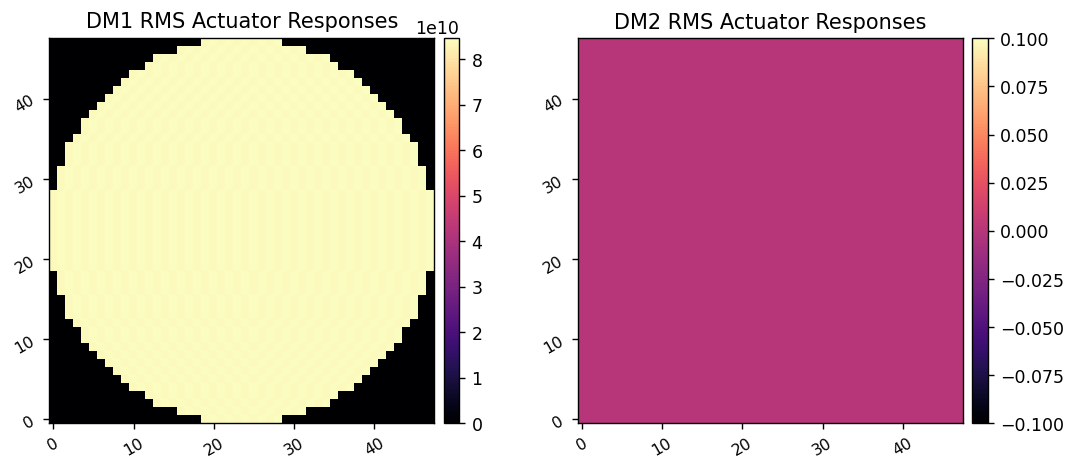

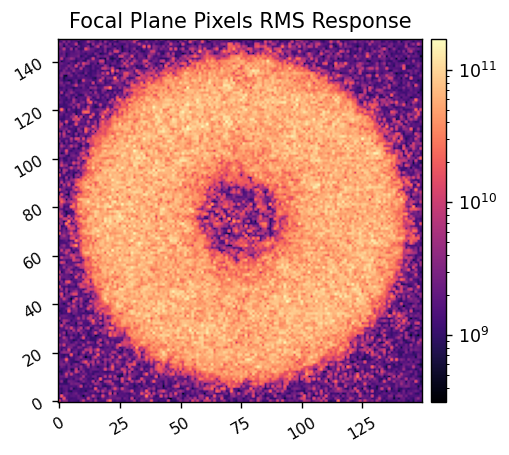

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20231220.fits


In [40]:
reload(iefc_2dm)

# calib_amp = 5e-9

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[:2], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
# utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [146]:
date = 20230912
date = 20230913
date = 20230918
date = 20230920
# date = 20230921
date = 20231017
date = 20231220
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_band4b_emccd_response_matrix_{date}.fits'))
response_info = fits.getheader(response_dir/f'spc_wide_band4b_emccd_response_matrix_{date}.fits')
display(response_info)
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_825_poke_modes_response_cube_{date}.fits'))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096                                                  
NAXIS2  =                40572                                                  
EM_GAIN =                  400                                                  
NFRAMES =                   10                                                  
EXP_TIME=                 0.05                                                  

In [21]:
xp.mean(response_matrix.dot(xp.array(calib_modes)), axis=0).shape

(4608,)

9753984875790.295


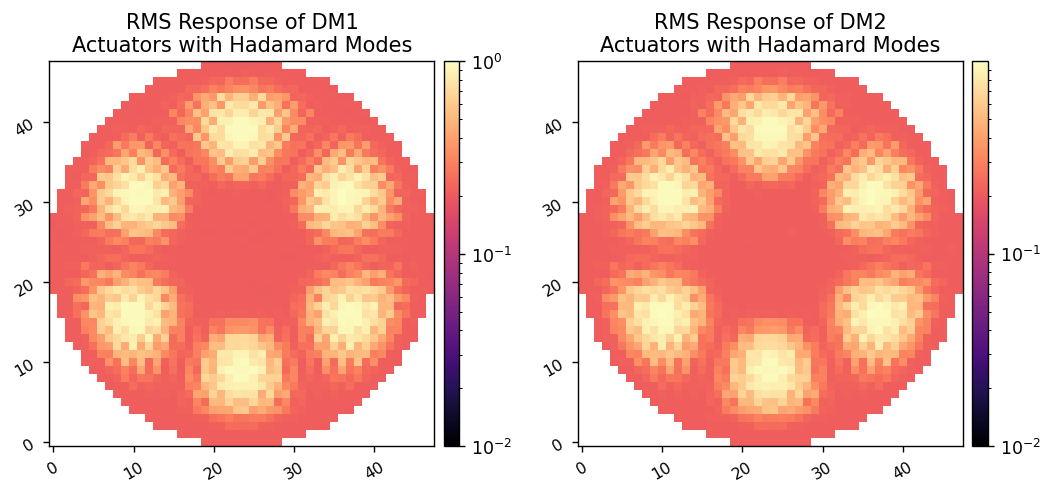

In [12]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )


# Run IEFC

In [39]:
mode.reset_dms()
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])

mode.reset_dms()

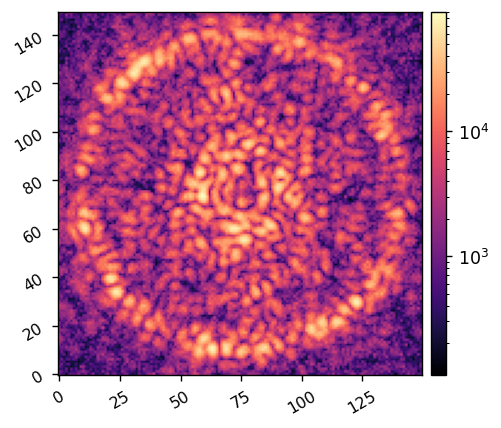

In [138]:
mode.normalize = False

mode.exp_time = 35
mode.Nframes = 5
mode.EMCCD.em_gain = 250

im = mode.snap()
imshow1(im, lognorm=True)

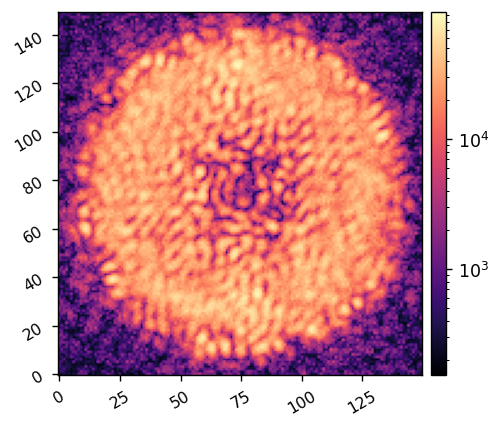

In [140]:
mode.normalize = False

mode.exp_time = 25
mode.Nframes = 10
mode.EMCCD.em_gain = 250

calib_amp = 2.5e-9
probe_amp = 5e-9

i = 2
# imshow1(calib_amp*calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))

# mode.add_dm1(calib_amp*calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp*probe_modes[0])
im = mode.snap()
mode.add_dm1(-probe_amp*probe_modes[0])
# mode.add_dm1(-calib_amp*calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))

imshow1(im, lognorm=True,)

In [143]:
reg_fun = utils.beta_reg
reg_conds = -2.5

Running iEFC...
	Closed-loop iteration 46 / 48


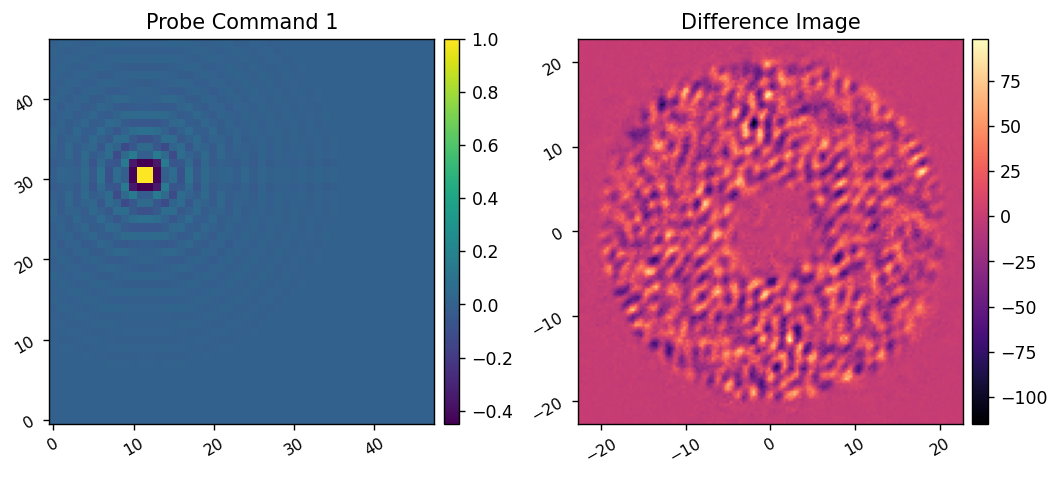

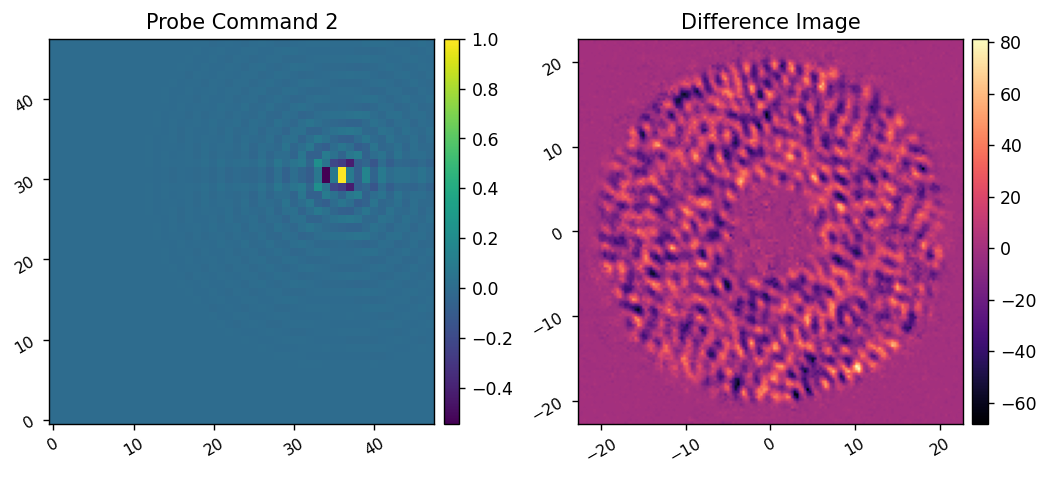

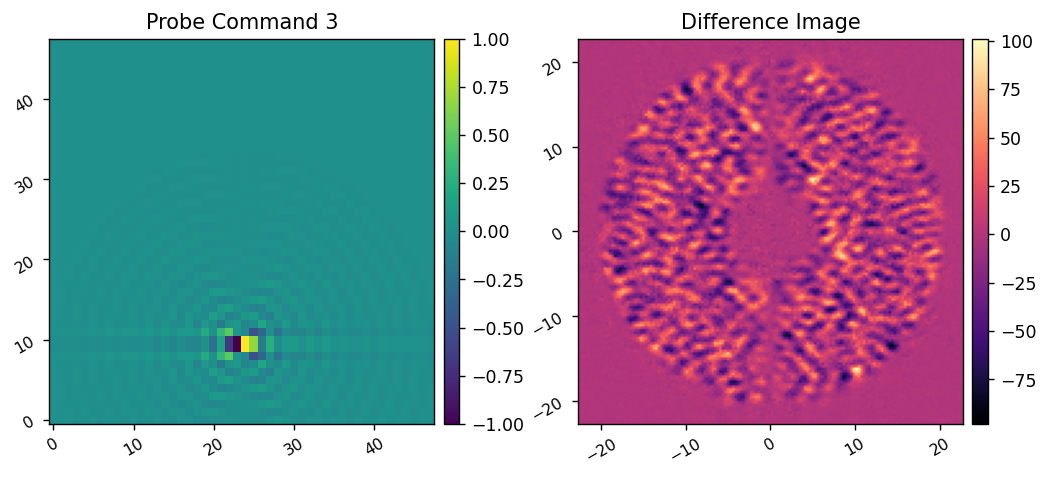

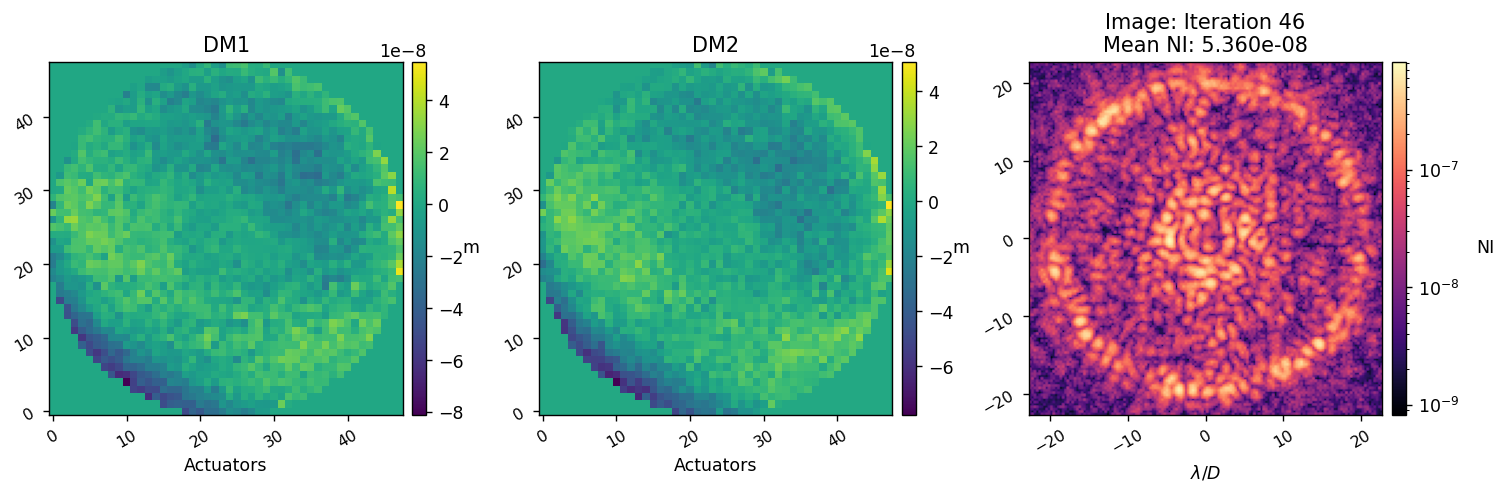

	Closed-loop iteration 47 / 48


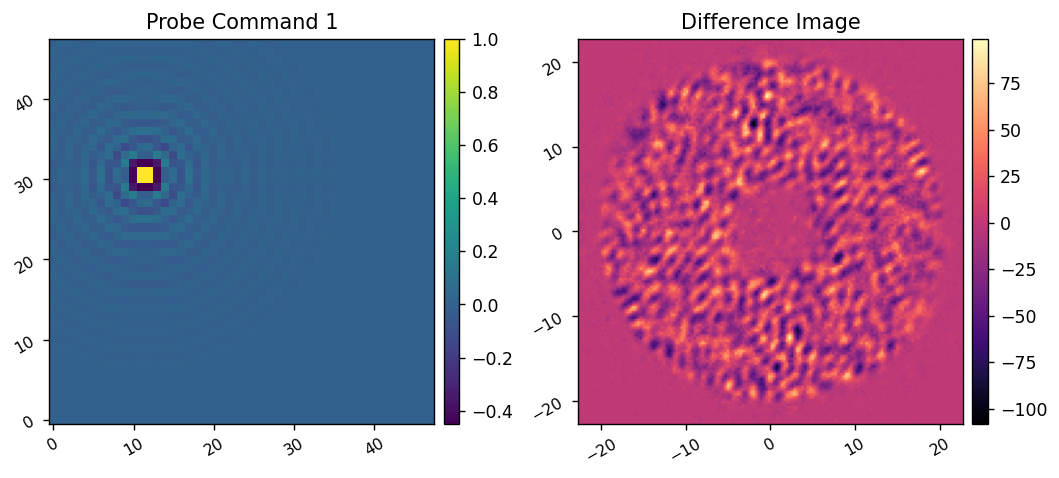

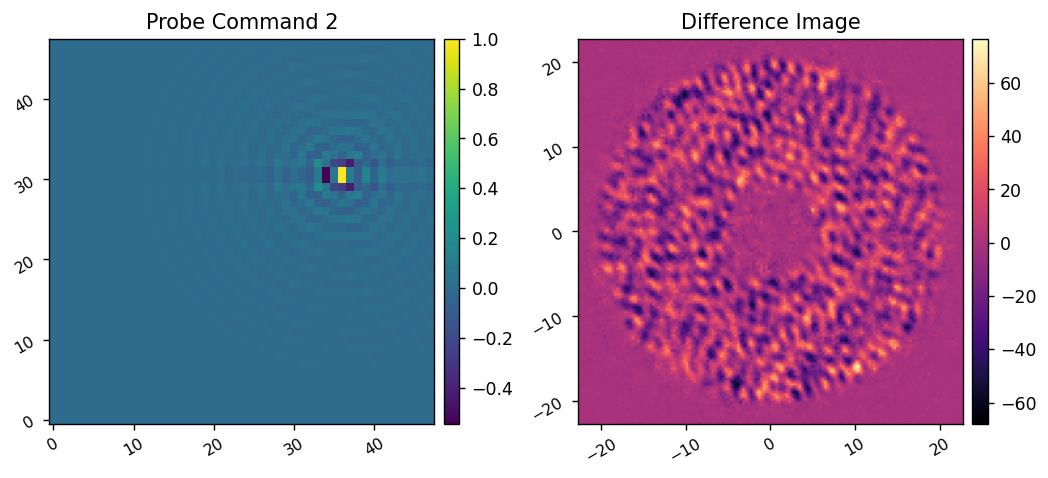

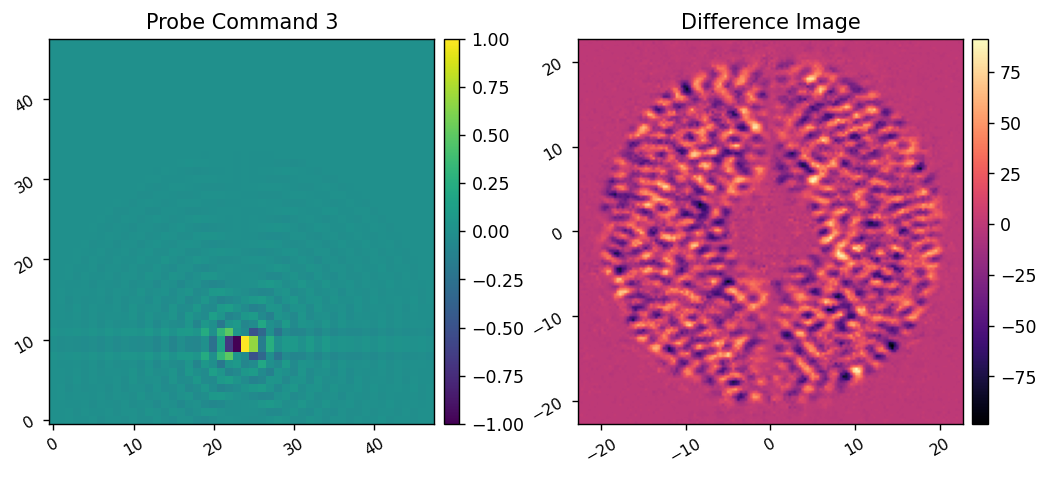

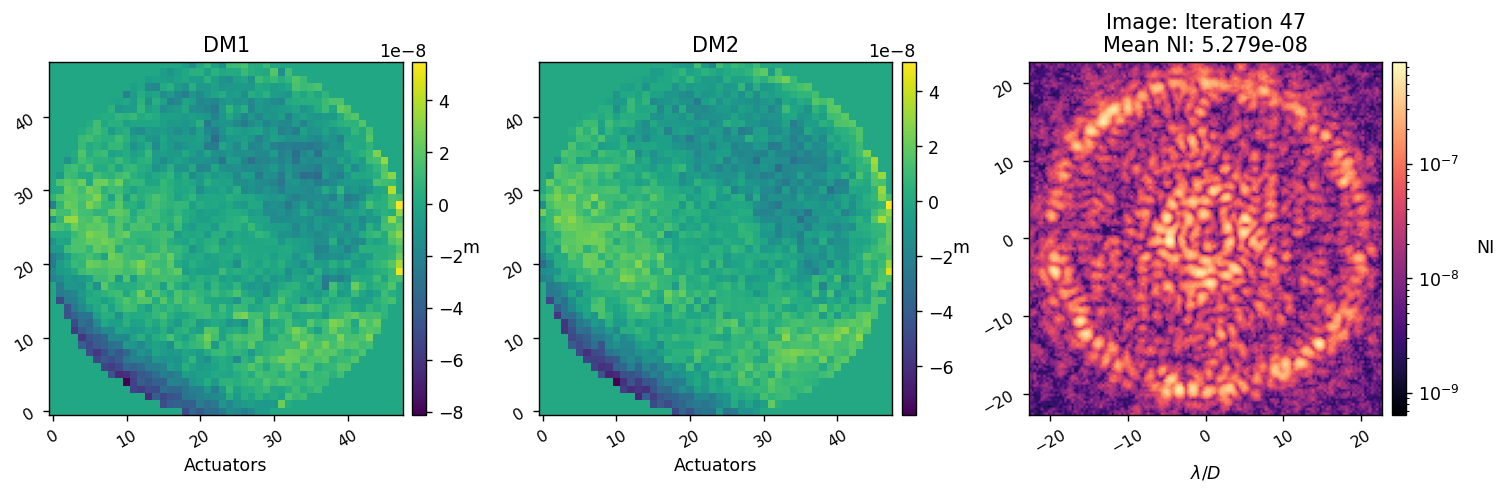

	Closed-loop iteration 48 / 48


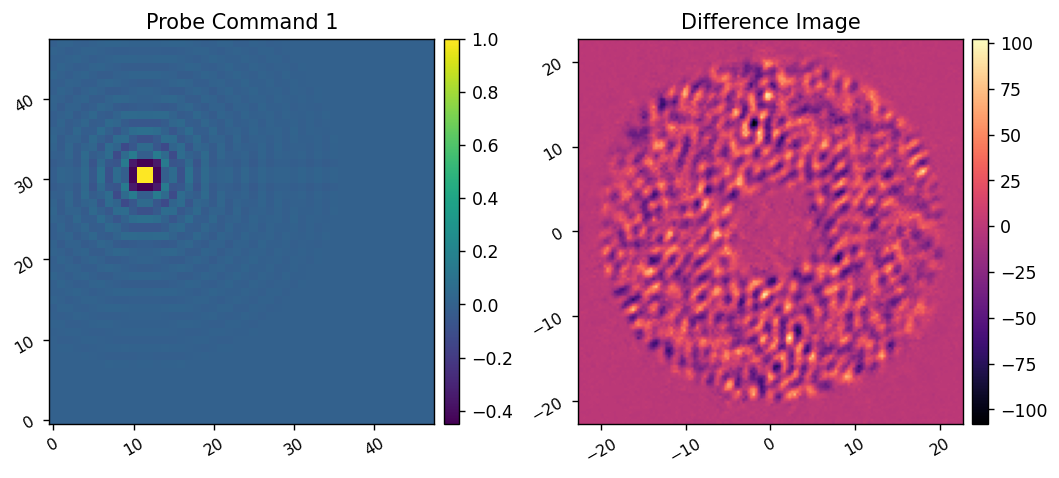

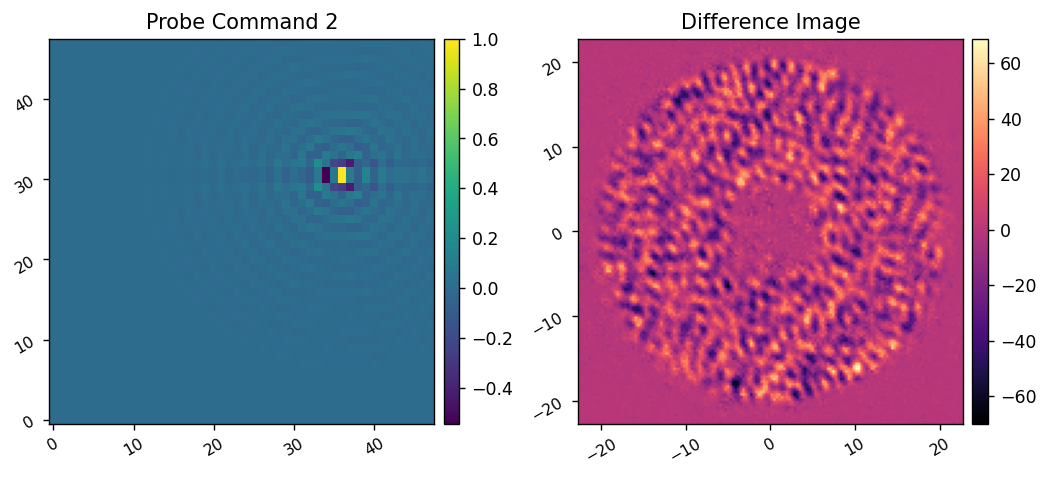

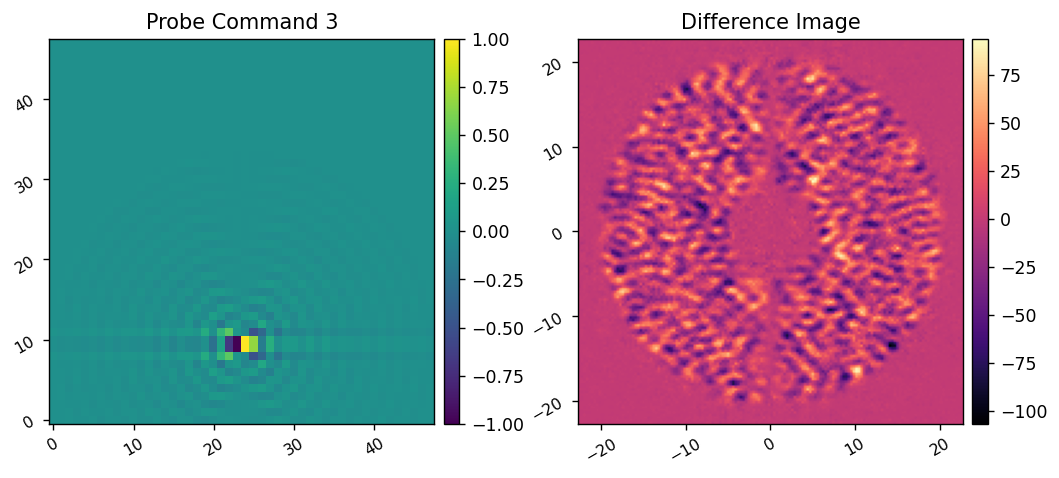

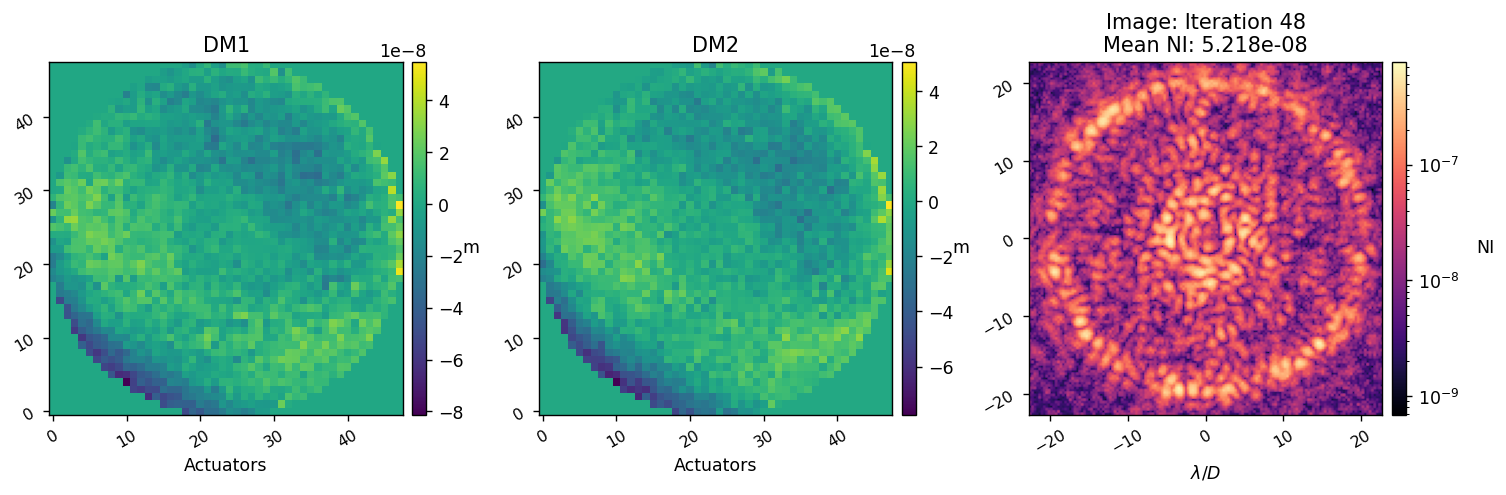

Closed loop for given control matrix completed in 26.782s.


In [144]:
reload(iefc_2dm)
reload(utils)

mode.normalize = True

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        response_matrix,
                                                        reg_fun, reg_conds, 
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                                                        probe_exp_time=25,
                                                        probe_nframes=10,
                                                        probe_em_gain=250,
                                                        metric_exp_time=35,
                                                        metric_nframes=5,
                                                        metric_em_gain=250,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                              )

In [147]:
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_dm1_commands_{today}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_dm2_commands_{today}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_images_{today}.fits', images)
# utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_regs_{today}.fits', regs)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_dm1_commands_20231221.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_dm2_commands_20231221.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_images_20231221.fits


AttributeError: 'list' object has no attribute 'get'